# TME 10 : Compression d'images avec le codage de Huffman
> Consignes: le fichier **TME10_Sujet.ipynb** est à déposer sur le site Moodle de l'UE https://moodle-sciences.upmc.fr/moodle-2018/course/view.php?id=4650. Si vous êtes en binôme, renommez-le en **TME10_nom1_nom2.ipynb**.

N'oubliez pas de sauvegarder fréquemment votre notebook !! ...

Pour chaque questions, écrivez des commentaires brefs et concis lorsque demandé dans les cases **Réponse**.

In [6]:
# Chargement des modules et fonctions utiles.
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


def affichage_14(affichages,titres=None, axis=True):
    # effectue entre 1 et 4 affichages avec leurs titres, pour des images ou courbes
    
    # paramètres :
    #  - liste des affichages (entre 1 et 4)
    #  - liste des titres (entre 1 et 4, autant que de affichages) Optionnelle
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('affichage_14 nécéssite 1 à 4 entrées en paramètre')        
        
    if nb_affichages != len(titres):
        raise ValueError('affichage_14 nécéssite autant de titres que d\'affichages')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True
        # ne pas afficher les axes si demandé
        if not axis:
            plt.axis('off')

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

def litbit(s,b):
    """ bytearray*int->str
        lit la valeur du bit b dans la table d'octets s
        et retourne '1' ou '0'
    """
    byte , bit = b//8 , 7-b%8
    if s[byte] & (1<<bit):
        return '1'
    else:
        return '0'

def ecritbit(s,b,val):
    """ bytearray*int*str -> NoneType
        len(str) == 1
        écrit la valeur du bit b dans la table d'octets s
    """
    byte , bit = b // 8 , 7 - b % 8
    if val == '1':
        s[byte] = s[byte] | (1<<bit)
    else:
        s[byte] = s[byte] & ~(1<<bit)

## Calcul d'entropie sur des images

Considérons un ensemble d'images en nuances de gris, notre source, et considérons la valeur de leurs pixels comme une variable aléatoire X ($X\in[0,255]$ la plus-part du temps).
On va dans un premier temps calculer l'entropie de X pour différentes sources, i.e différents groupes d'images.

### Question 1 :
1. Charger plusieurs images dans des tableaux ```np.array()``` dont une image binaire (par exemple ``rectangle.png``), puis affichez-les (on pourra grouper les images par groupe de 4 maximum et utiliser la fonction ```affichage_14()```).

2. Calculer l'entropie pour chaque image (une image est vue comme la réalisation d'une variable aléatoire, et donc une suite de symboles). Indication: utiliser la fonction ``np.histogram(img,256)`` du module Numpy. 

3. Quelle différence y a-t-il entre l'entropie de l'image binaire et celle des images non binaires ? Pourquoi ?

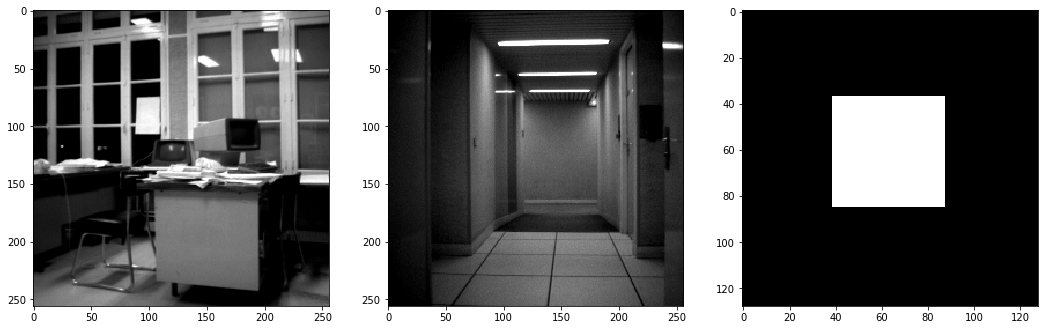

In [7]:
### Reponse 1.1
import numpy as np
from PIL import Image
bureau=np.array(Image.open('images/bureau.png'))
couloir=np.array(Image.open('images/couloir.png'))
rectangle=np.array(Image.open('images/rectangle.png'))
affichage_14([bureau,couloir,rectangle])

In [28]:
### Réponse 1.2
import math
histo_bureau=np.histogram(bureau,256)
histo_couloir=np.histogram(couloir,256)
histo_rectangle=np.histogram(rectangle,256)
def entropie(histo):
    e=0.0
    for i in range(256):
        if histo[i]!=0:            
            hn=histo[i]/sum(histo)
            e-=hn*math.log(hn,2)
    return e
print(entropie(histo_bureau[0]))
print(entropie(histo_couloir[0]))
print(entropie(histo_rectangle[0]))

6.905430443715126
6.083237550374505
0.5934730428271714


### Réponse 1.3


image binaire: entropie max=1
image non binaire:(niveau de gris 256:entropie max=8)

## Encodage des pixels avec le code de Huffman
On suppose ici connaître la dimension des images (donc leur nombre de pixels et leur nombre de lignes), et on souhaite encoder ces images en séquences binaires les plus compactes possibles.
On va pour cela utiliser le codage de Huffman.

### Question 2
1. Écrire la fonction ``huffman()`` vue  en TD. 

In [30]:
# type Noeud = tuple[int,float,list[Noeud]]

def huffman(hisn):
    """ Array[float] -> Noeud
        construit l'arbre de huffman correspondant a
        l'histogramme normalise hisn et retourne la racine.
    """
    vp=[(i,hisn[i],[]) for i in range (len(hisn)) if hisn[i]>0]
    while len(vp)>1:
        vp=sorted(vp,key=lambda x:x[1])
        l0,l1=vp[0],vp[1]
        vp=vp[2:]
        vp.append((-1,l0[1]+l1[1],[l0,l1]))
    return vp[0]

2. Testez la sur l'exemple du TD en imprimant l'arbre.

In [31]:
histo_td = np.zeros(256)
for v,f in [(0,12046),(36,3325),(73,2390),(109,8716),(146,19544),(182,18748),(219,594),(255,178)]:
    histo_td[v] = f
###
print(huffman(histo_td))

(-1, 65541.0, [(-1, 27249.0, [(0, 12046.0, []), (-1, 15203.0, [(-1, 6487.0, [(-1, 3162.0, [(-1, 772.0, [(255, 178.0, []), (219, 594.0, [])]), (73, 2390.0, [])]), (36, 3325.0, [])]), (109, 8716.0, [])])]), (-1, 38292.0, [(182, 18748.0, []), (146, 19544.0, [])])])


### Question 3
1. Écrire la fonction ```hufftable()``` vu en TD.

In [39]:
def hufftable(racine):
    """ Noeud -> dict[int,str] """
    def litcode(nd,code):
        val,p,fils=nd
        if len(fils)>0:
            cp=code
            litcode(fils[0],code+"0")
            code=cp
            litcode(fils[1],code+"1")
        else:
            table[val]=code
        del nd
        
    table=dict()
    litcode(racine,"")
    return table

2. Tester la sur l'arbre calculé précédemment et afficher la table

In [43]:
hTable=hufftable(huffman(histo_td))
print(hTable)

{0: '00', 146: '11', 36: '0101', 182: '10', 73: '01001', 219: '010001', 109: '011', 255: '010000'}


### Question 4
1. Écrire la fonction ``encode()`` vue en TD.

In [51]:
def encode(img,table):
    """ Array[int] * dict[int,str] -> tuple[bytearray,int]
        Encode l'image img selon la table de Huffman table
        retourne un tableau d'octets et la véritable longueur
        en bit des données encodés
    """
    code=""
    for p in img.reshape():
        code=code+table[p]
    return code,len(img.reshape())

2. Tester la sur la portion d'image utilisée en TD. Afficher la taille en bit avant et après encodage.

In [52]:
img_td = np.array([
    [109, 182, 109, 109, 219, 109, 146, 182], 
    [146, 219, 182, 182, 255, 219, 219, 182],
    [219, 219, 219, 219, 219, 219, 219, 182],
    [36, 182, 73, 73, 219, 73, 109, 182], 
    [36, 146, 73, 73, 182, 73, 109, 182],
    [36, 109, 73, 73, 109, 73, 146, 182],
    [73, 36, 36, 36, 182, 146, 182, 182],
    [182, 146, 146, 146, 182, 182, 182, 182]
],dtype=int)
print(encode(img_td,hTable))

TypeError: reshape() takes exactly 1 argument (0 given)

3. Écrire une fonction ``print_encode()`` qui imprime le tampon encodé sous la forme d'une suite de caractères '0' et
'1'. Tester la sur l'exemple précédent.

In [ ]:
def print_encoded( encoded, l):
    """ bytearray*int->str"""
    

### Question 5
1. Écrire le code de la fonction ```decode()``` vu en TD.

In [ ]:
def decode(encoded,shape,table):
    """ bytearray*tuple[int,int]*dict[int,str]->Array[int]
        decode une image de huffman
    """

2. Tester la sur la portion d''image précédemment encodée et vérifier qu'elle est bien égale à la portion d'image originale.

### Question 5: expérimentations

1. Vérifier, pour les trois images, que la compression huffman fonctionne correctement

2. On définit le taux de compression d'une image par : *1 - (taille_bit_code / taille_bit_image) %* Calculez les taux de compression des trois images. Commentez.  
 
3. Quel serait le taux de compression d'une image avec pixels aléatoires de loi uniforme [0,255] ? Quel est le lien avec la valeur de l'entropie des pixels ?

In [ ]:
# Réponse questions 5.1 et 5.2


**Réponse question 5.3**